In [3]:
from blop.utils import prepare_re_env

%run -i C:\\Users\\megha\\src\\blop\\src\\blop\\utils\\prepare_re_env.py --db-type=temp

bec.disable_plots()

In [4]:
from blop.sim import Beamline

bl = Beamline(name="bl")

In [5]:
import gpytorch
import torch

In [6]:
import bluesky.plans as bp

# RE(bp.scan([bl.det], bl.kbv_usv, -2, 2, 11))

In [7]:
def process_beam(image): 

    image = image - image.min()
    
    flux = image.sum()
    im2 = image
    # Perform SVD
    U, S, Vt = np.linalg.svd(image)

    # Reconstruct the image using the first few singular values
    k = 1  # Number of singular values to use
    reconstructed = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    
    column_sums = np.sum(reconstructed, axis = 0)
    row_sums = np.sum(reconstructed, axis = 1)
    
    height_threshold = np.mean(row_sums) + 0.75 * np.std(row_sums)
    
    # Find the indices where the row sums cross the threshold
    above_threshold_h = np.where(row_sums > height_threshold)[0]
    if len(above_threshold_h) > 1:
        start_index_h = above_threshold_h[0]
        end_index_h = above_threshold_h[-1]
        height = end_index_h-start_index_h
        im2 = im2[start_index_h: end_index_h]
        ypos = (end_index_h+start_index_h)/2
    else: 
        height = 1
        ypos = 0
    
    width_threshold = np.mean(column_sums) + 0.75 * np.std(column_sums)
    above_threshold_w = np.where(column_sums > width_threshold)[0]
    # Find the indices where the column sums cross the threshold
    if len(above_threshold_w) > 1:
        start_index_w = above_threshold_w[0]
        end_index_w = above_threshold_w[-1]
        width = end_index_w-start_index_w
        im2 = im2 [:, start_index_w: end_index_w]
        xpos = (end_index_w+start_index_w)/2
    else: 
        width = 1
        xpos = 0

    flux = im2.sum() if im2.sum() > 0 else 1
    #return width, height, flux
    return width, height, flux, xpos, ypos
    #return np.log(width), np.log(height), np.log(flux)

In [194]:
from blop import DOF, Objective, Agent


def digestion(df,  image_key="bl_det_image", **kwargs):
   
    for index, entry in df.iterrows():

        image = entry.loc[image_key]

        w, h, f, x, y = process_beam(image)

        df.loc[index, "flux"] = f
        df.loc[index, "width"] = w
        df.loc[index, "height"] = h
        df.loc[index, "x_pos"] = x
        df.loc[index, "y_pos"] = y
        
    return df


dofs = [DOF(device=bl.kbv_usv, search_domain=(-7, 7)), 
      DOF(device=bl.kbv_dsv, search_domain=(-7, 7)), 
      DOF(device=bl.kbh_ush, search_domain=(-7, 7)), 
      DOF(device=bl.kbh_dsh, search_domain=(-7, 7))]

objectives = [
    Objective(name="width", transform="log", trust_domain=(1, 300), target="min", latent_groups=[("bl_kbh_ush", "bl_kbh_dsh")]),
    Objective(name="height", transform="log", trust_domain=(1, 250), target="min", latent_groups=[("bl_kbv_usv", "bl_kbv_dsv")]),
    Objective(name="flux", transform="log"), #, trust_domain=(200, np.inf)),
    Objective(name="x_pos", weight=0),
    Objective(name="y_pos", weight=0),
]

agent = Agent(dofs=dofs, 
              objectives=objectives, 
              detectors=[bl.det],
              digestion=digestion,
              enforce_all_objectives_valid=True,
              db=db)

In [195]:
RE(agent.learn("qr", n=16))



Transient Scan ID: 45     Time: 2024-07-26 13:14:11
Persistent Unique Scan ID: 'c20416da-2f88-4e8c-b9d3-a6d7bbb356b1'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 13:14:11.2 |     -3.133 |     -4.057 |     -1.512 |     -3.132 |      8.676 |      228.231 |      142.696 |       91.834 |       97.956 |
|         2 | 13:14:11.3 |     -0.531 |     -0.465 |      0.795 |     -6.298 |    119.690 |      271.706 |      147.256 |       49.138 |       57.422 |
|         3 | 13:14:11.4 |     -2.308 |      2.425 |      3.684 |     -3.652 |      2.305 |      2

('c20416da-2f88-4e8c-b9d3-a6d7bbb356b1',)

In [ ]:
agent.latent_transforms

In [202]:
for iteration in range(4):
    #I need to redigest every once in a while to make this dynamic
    #Q: is there a good way to redigest only what we need to to save time?
    #if iteration % 3 == 0:
        #agent.redigest()
        
    #train targets may not be the right thing to use? 
    w_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.width.model.likelihood, agent.objectives.width.model)
    h_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.height.model.likelihood, agent.objectives.height.model)
    x_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.x_pos.model.likelihood, agent.objectives.x_pos.model)
    y_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.y_pos.model.likelihood, agent.objectives.y_pos.model)


    agent.redigest()
    w_mlls = w_mll(agent.objectives.width.model(agent.train_inputs()), agent.train_targets()["width"].unsqueeze(-1)).detach()
    h_mlls = h_mll(agent.objectives.height.model(agent.train_inputs()), agent.train_targets()["height"].unsqueeze(-1)).detach()
    x_mlls = x_mll(agent.objectives.x_pos.model(agent.train_inputs()), agent.train_targets()["x_pos"].unsqueeze(-1)).detach()
    y_mlls = y_mll(agent.objectives.y_pos.model(agent.train_inputs()), agent.train_targets()["y_pos"].unsqueeze(-1)).detach()

    #use y-mean/ std.
    agent.table.loc[:, "w_loss"] = w_mlls.numpy()
    agent.table.loc[:, "h_loss"] = h_mlls.numpy()
    agent.table.loc[:, "x_loss"] = x_mlls.numpy()
    agent.table.loc[:, "y_loss"] = y_mlls.numpy()
    
    mask  = ((agent.table.w_loss < 1.25 * np.quantile([x for x in w_mlls if not np.isnan(x)], q=0.25))
             | (agent.table.h_loss < 1.25 * np.quantile([x for x in h_mlls if not np.isnan(x)], q=0.25))
             | (agent.table.x_loss < 1.2 * np.quantile([x for x in x_mlls if not np.isnan(x)], q=0.25))
             | (agent.table.y_loss < 1.2 * np.quantile([x for x in y_mlls if not np.isnan(x)], q=0.25))
            )
    print(mask)
    agent.table.loc[mask, "width"]= np.nan
    agent.table.loc[mask, "height"]= np.nan
    agent.table.loc[mask, "flux"]= np.nan

    agent._construct_all_models()
    agent._train_all_models()

    RE(agent.learn("qei", n=2, iterations=1))

0     False
1      True
2     False
3      True
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14     True
15    False
16     True
17    False
18    False
19     True
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27     True
dtype: bool


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(




Transient Scan ID: 52     Time: 2024-07-26 13:19:28
Persistent Unique Scan ID: 'e9ae02ab-e5b8-4cd9-9d05-f6d1ae0060cc'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 13:19:28.3 |      0.745 |     -2.078 |      0.537 |      4.436 |    277.179 |      138.060 |      188.708 |       69.916 |       60.994 |
|         2 | 13:19:28.4 |     -0.402 |      1.763 |     -1.622 |      0.860 |    547.008 |      149.500 |      116.784 |       49.007 |       15.367 |
+-----------+------------+------------+------------+------------+------------+------------+-------

C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


0     False
1      True
2     False
3      True
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14     True
15    False
16     True
17    False
18    False
19     True
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
dtype: bool


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message



Transient Scan ID: 53     Time: 2024-07-26 13:19:51
Persistent Unique Scan ID: 'd9e0c255-02da-405c-98ee-6873958ca836'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 13:19:51.5 |      4.053 |      0.953 |     -0.582 |      0.711 |    466.699 |      173.250 |      192.509 |       28.458 |       54.238 |
|         2 | 13:19:51.6 |     -1.891 |     -4.087 |     -0.389 |      4.191 |     87.595 |      124.120 |      161.687 |       44.292 |      110.077 |
+-----------+------------+------------+------------+------------+------------+------------+-------

C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(




Transient Scan ID: 54     Time: 2024-07-26 13:20:12
Persistent Unique Scan ID: '31fe4240-0c7b-4f5f-8cc9-30052208330c'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 13:20:13.1 |     -2.324 |     -1.846 |      0.259 |      4.054 |    204.314 |      134.762 |      142.839 |       63.071 |      112.198 |
|         2 | 13:20:13.2 |      1.732 |     -0.150 |     -1.210 |      1.252 |    545.774 |      149.654 |      177.075 |       29.926 |       12.111 |
+-----------+------------+------------+------------+------------+------------+------------+-------

C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


0     False
1      True
2     False
3      True
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14     True
15    False
16     True
17    False
18    False
19     True
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
dtype: bool


Transient Scan ID: 55     Time: 2024-07-26 13:20:32
Persistent Unique Scan ID: 'ad3aab8c-0e69-48f8-bf8d-52afb6c71ce4'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+-------------

In [200]:
np.quantile([x for x in agent.table.w_loss.values if not np.isnan(x)], q=0.25)

-519.734729727688

In [ ]:
mask

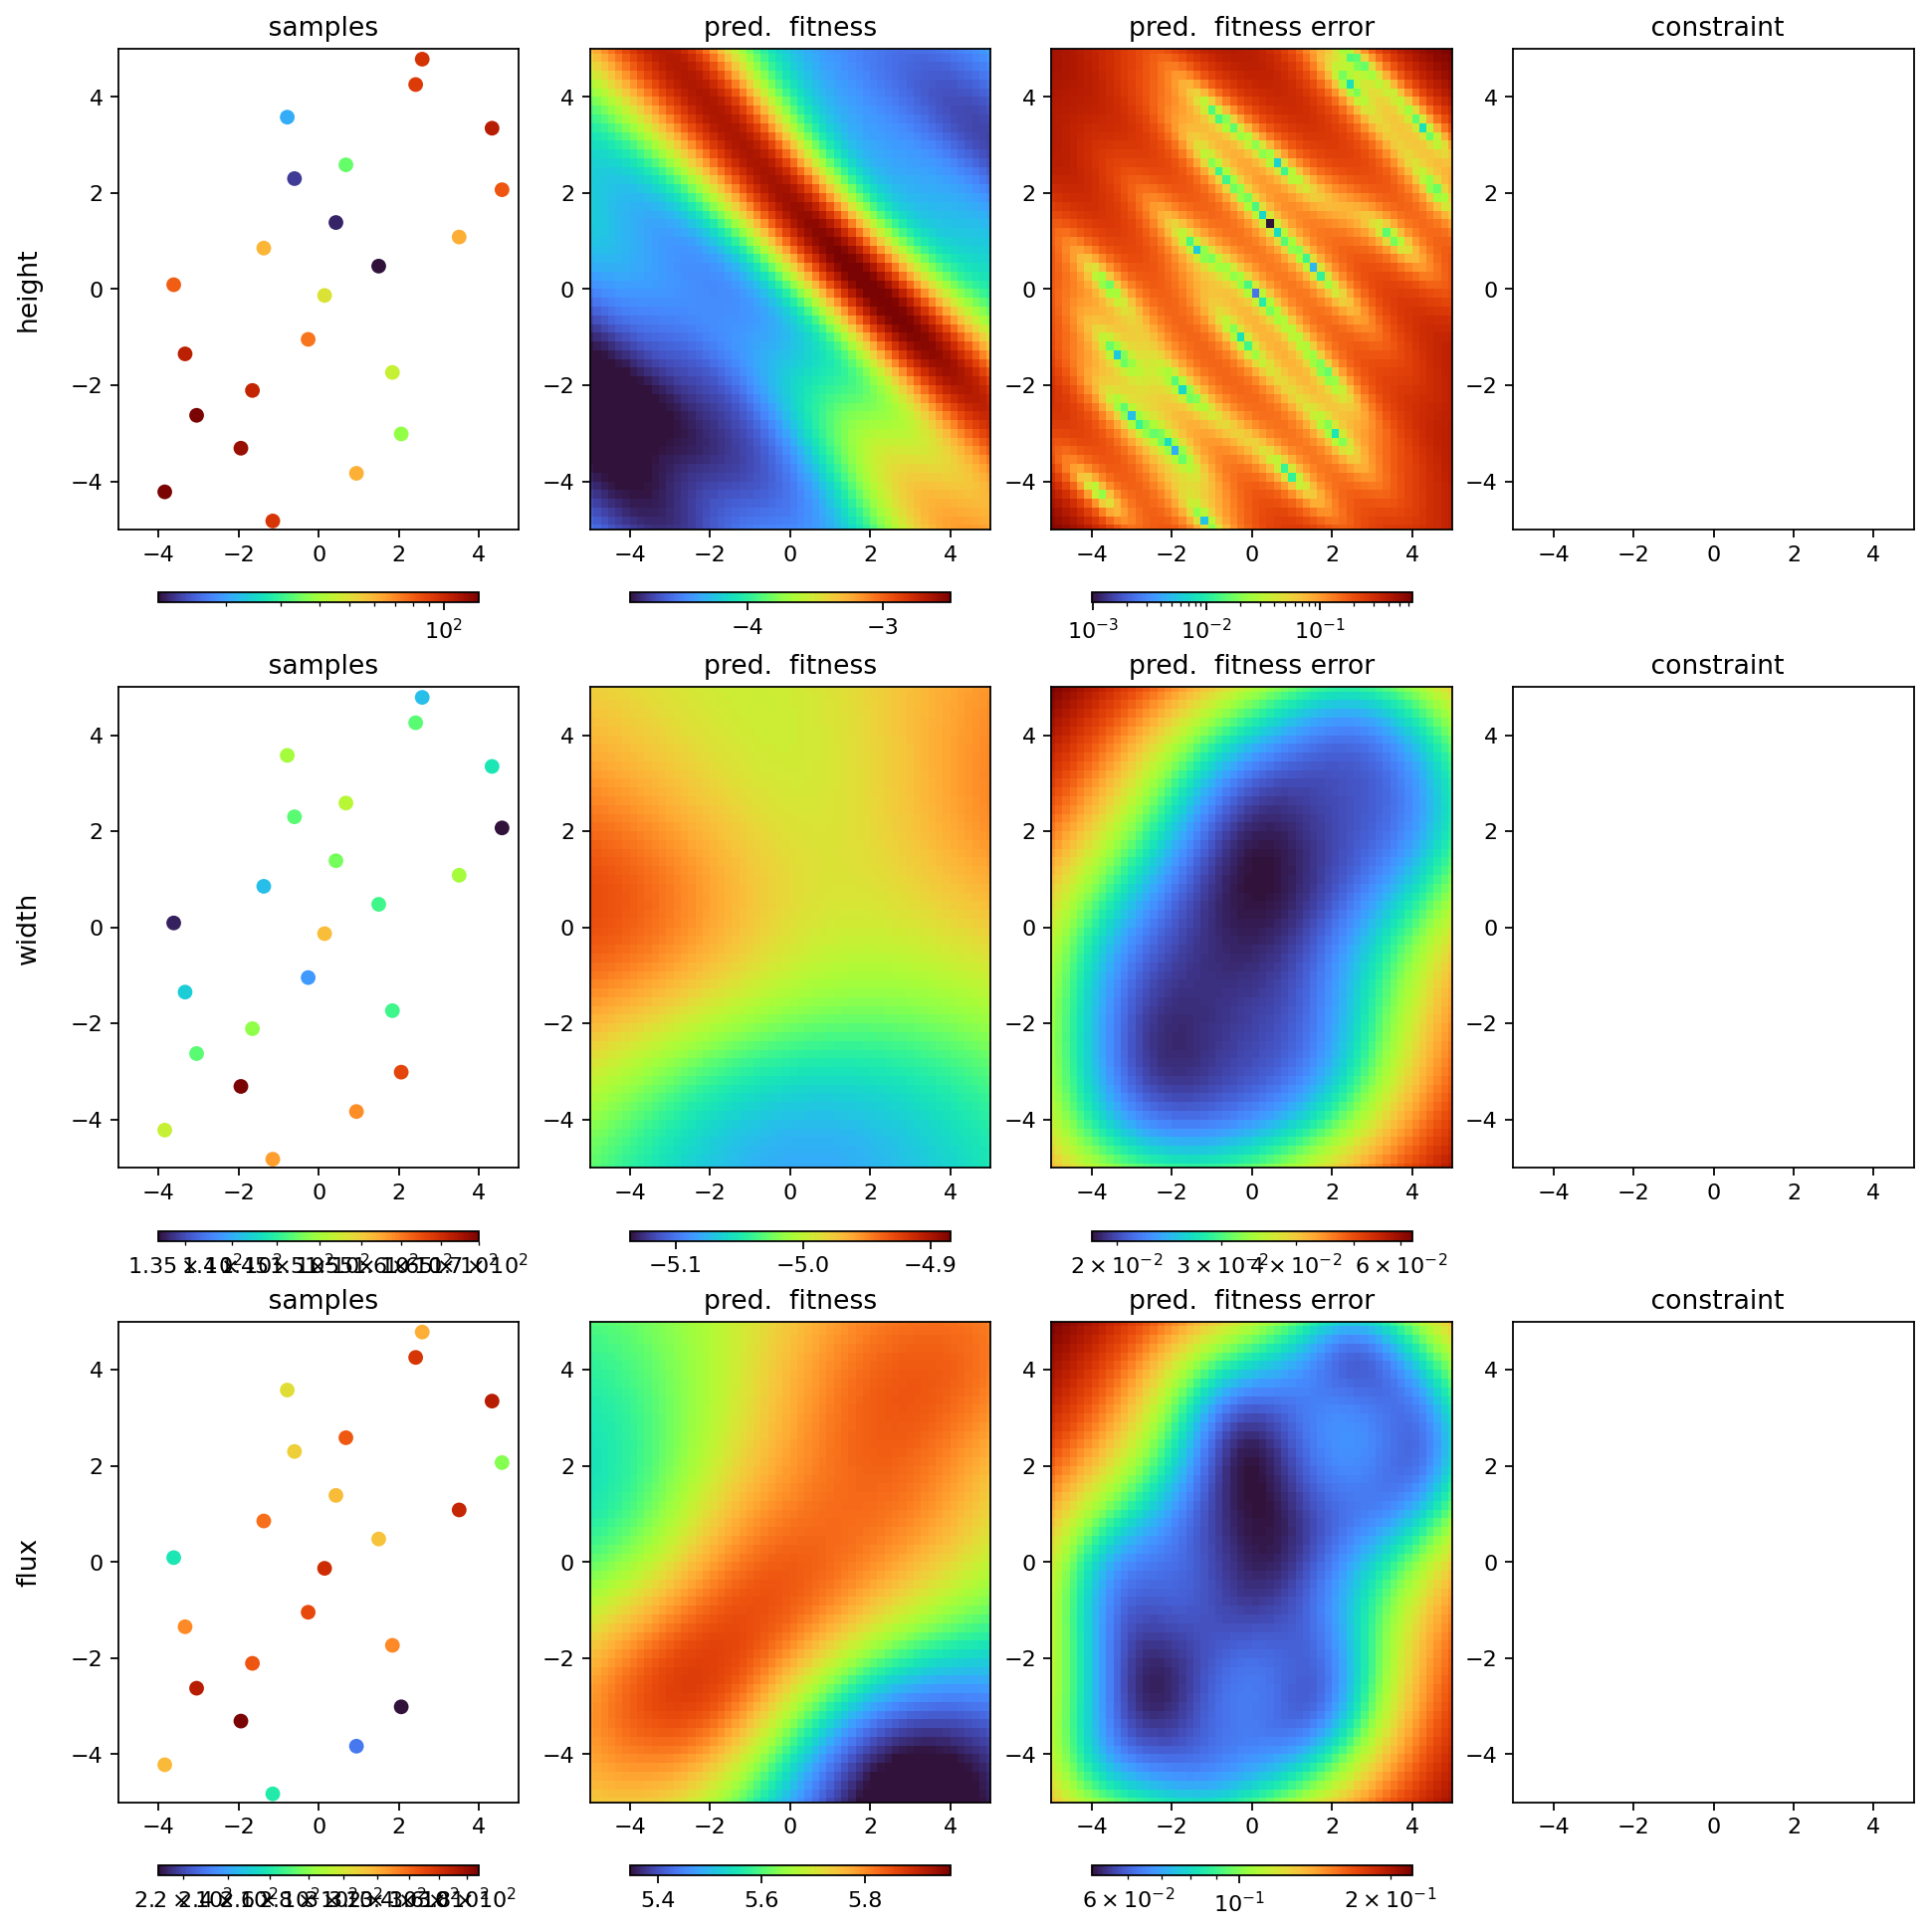

In [29]:
agent.plot_objectives()

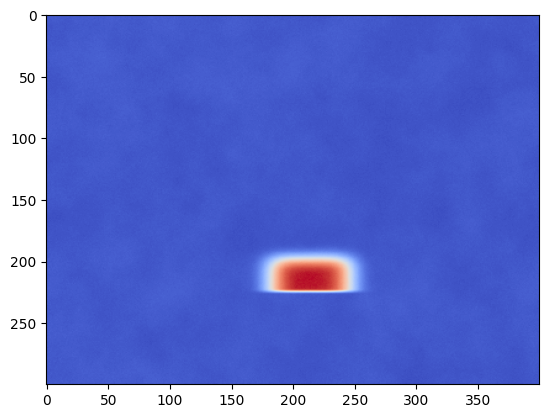

In [52]:
plt.imshow(agent.best.bl_det_image)

In [50]:
RE(agent.learn("qr", n=2, iterations=2))



Transient Scan ID: 11     Time: 2024-07-08 12:52:11
Persistent Unique Scan ID: '246b8905-b0fe-4b4e-a708-ccbab9ca468c'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 12:52:11.6 |     -3.374 |     -1.285 |     -4.597 |      2.540 |     13.805 |      104.061 |      123.655 |        8.937 |       89.556 |
|         2 | 12:52:11.8 |      6.122 |      3.798 |      6.095 |     -0.229 |     56.296 |      279.098 |      163.506 |       34.785 |      108.009 |
+-----------+------------+------------+------------+------------+------------+------------+-------

('246b8905-b0fe-4b4e-a708-ccbab9ca468c',
 '77a153bf-c1b7-483e-bc52-840e3661fdb5')

In [16]:
agent.table

bl_kbv_usv  bl_kbv_dsv  bl_kbh_ush  bl_kbh_dsh  width  height  \
0    -2.120286   -1.843495   -2.208159   -4.885298  138.0   107.0   
1    -0.179561    0.444765   -3.555889   -6.774352  170.0    44.0   
2     1.827526   -6.876084   -6.903980   -1.459238  316.0    42.0   
3     5.595466   -3.881556   -3.177764    1.494723  292.0   173.0   
4     4.699692   -0.633878    0.423855    5.669659   79.0    24.0   
5     6.145987    1.859572    6.050882    3.781781  141.0    72.0   
6    -2.677616    3.790389    6.828713   -0.391099  366.0   194.0   
7    -6.551720    6.893758    3.116169    0.375376  399.0   299.0   
8    -3.743377    2.810414   -0.280389    6.679633  111.0   175.0   
9    -5.359075   -1.474073   -5.921124    4.849913  397.0   299.0   
10   -4.498121   -4.790498    4.463455    1.987199  118.0   146.0   
11   -1.174844   -5.952595    1.188389   -2.060548   65.0    89.0   
12    1.029698   -2.670868    3.713027   -5.596838  176.0    94.0   
13    3.027034    1.381097    2.324244   -3.765944   28.0    57.0   
14    0.268145    4.603208   -1.277398   -3.070529  129.0    45.0   
15    3.711270    6.093749   -4.566136    3.164707  307.0   275.0   
16    1.634548    6.205671   -4.960262   -5.427922  197.0    71.0   
17   -1.029737    4.406708   -0.969693   -4.547394  125.0    15.0   
18    0.378468    3.355144    1.765125   -4.188761   44.0    44.0   
19    4.029780    1.655941    2.535496   -0.476058   42.0    78.0   
20    1.131285    1.125198    2.717834   -0.047664   59.0    14.0   
21    5.653996    0.704638    2.983895   -0.209148   61.0    52.0   
22    1.215658    0.809278    1.895153    0.170166   42.0    12.0   
23    1.430607   -2.219181    3.068508   -3.608407  363.0    61.0   
24    2.908723   -0.754024    1.921782   -0.062404   38.0    13.0   
25    1.011264    3.338744   -0.844846   -5.396227  117.0    57.0   

           flux  x_pos  y_pos                          time  ...  \
0    326.240346  229.0  146.5 2024-07-10 16:49:01.111225128  ...   
1    302.350441  213.0  140.0 2024-07-10 16:49:01.300470352  ...   
2    159.039564  186.0  204.0 2024-07-10 16:49:01.444849968  ...   
3    445.007505  232.0   92.5 2024-07-10 16:49:01.595763922  ...   
4    106.947037  139.5  213.0 2024-07-10 16:49:01.732260466  ...   
5    213.407322  227.5  188.0 2024-07-10 16:49:01.874429464  ...   
6    549.736675  197.0  198.0 2024-07-10 16:49:02.030937433  ...   
7   1001.797915  199.5  149.5 2024-07-10 16:49:02.185582638  ...   
8    199.372489  155.5  161.5 2024-07-10 16:49:02.333271503  ...   
9   1088.794107  199.5  149.5 2024-07-10 16:49:02.471448421  ...   
10   351.167019  240.0  149.0 2024-07-10 16:49:02.673623085  ...   
11   237.259230  263.5  179.5 2024-07-10 16:49:02.858874083  ...   
12   171.707864  195.0   49.0 2024-07-10 16:49:03.062279224  ...   
13   120.020328  286.0  174.5 2024-07-10 16:49:03.199670315  ...   
14   294.532925  233.5   97.5 2024-07-10 16:49:03.344670296  ...   
15   745.261553  156.5  144.5 2024-07-10 16:49:03.517170668  ...   
16   258.405248  199.5  110.5 2024-07-10 16:49:43.896098375  ...   
17   104.026729  235.5   81.5 2024-07-10 16:49:44.056098700  ...   
18   165.358970  278.0  105.0 2024-07-10 16:50:02.649171114  ...   
19   464.972377  260.0  184.0 2024-07-10 16:50:02.823592186  ...   
20   497.353801  254.5  150.0 2024-07-10 16:50:21.332527637  ...   
21   255.056667  263.5  198.0 2024-07-10 16:50:21.502139807  ...   
22   498.637508  234.0  156.0 2024-07-10 16:50:55.241461992  ...   
23   228.295186  184.5  256.5 2024-07-10 16:50:55.400925875  ...   
24   512.558613  239.0  204.5 2024-07-10 16:51:26.116361618  ...   
25   291.592879  240.5  114.5 2024-07-10 16:51:26.257989407  ...   

    bl_det_wid_x  bl_det_wid_y  \
0     103.647029     93.949386   
1     154.143889     33.499311   
2      87.586538     34.797802   
3     367.677308    259.055952   
4      62.057416     16.543478   
5     130.404190     49.790723   
6     351.583167    221.093182   
7     370.197758    264.183656 

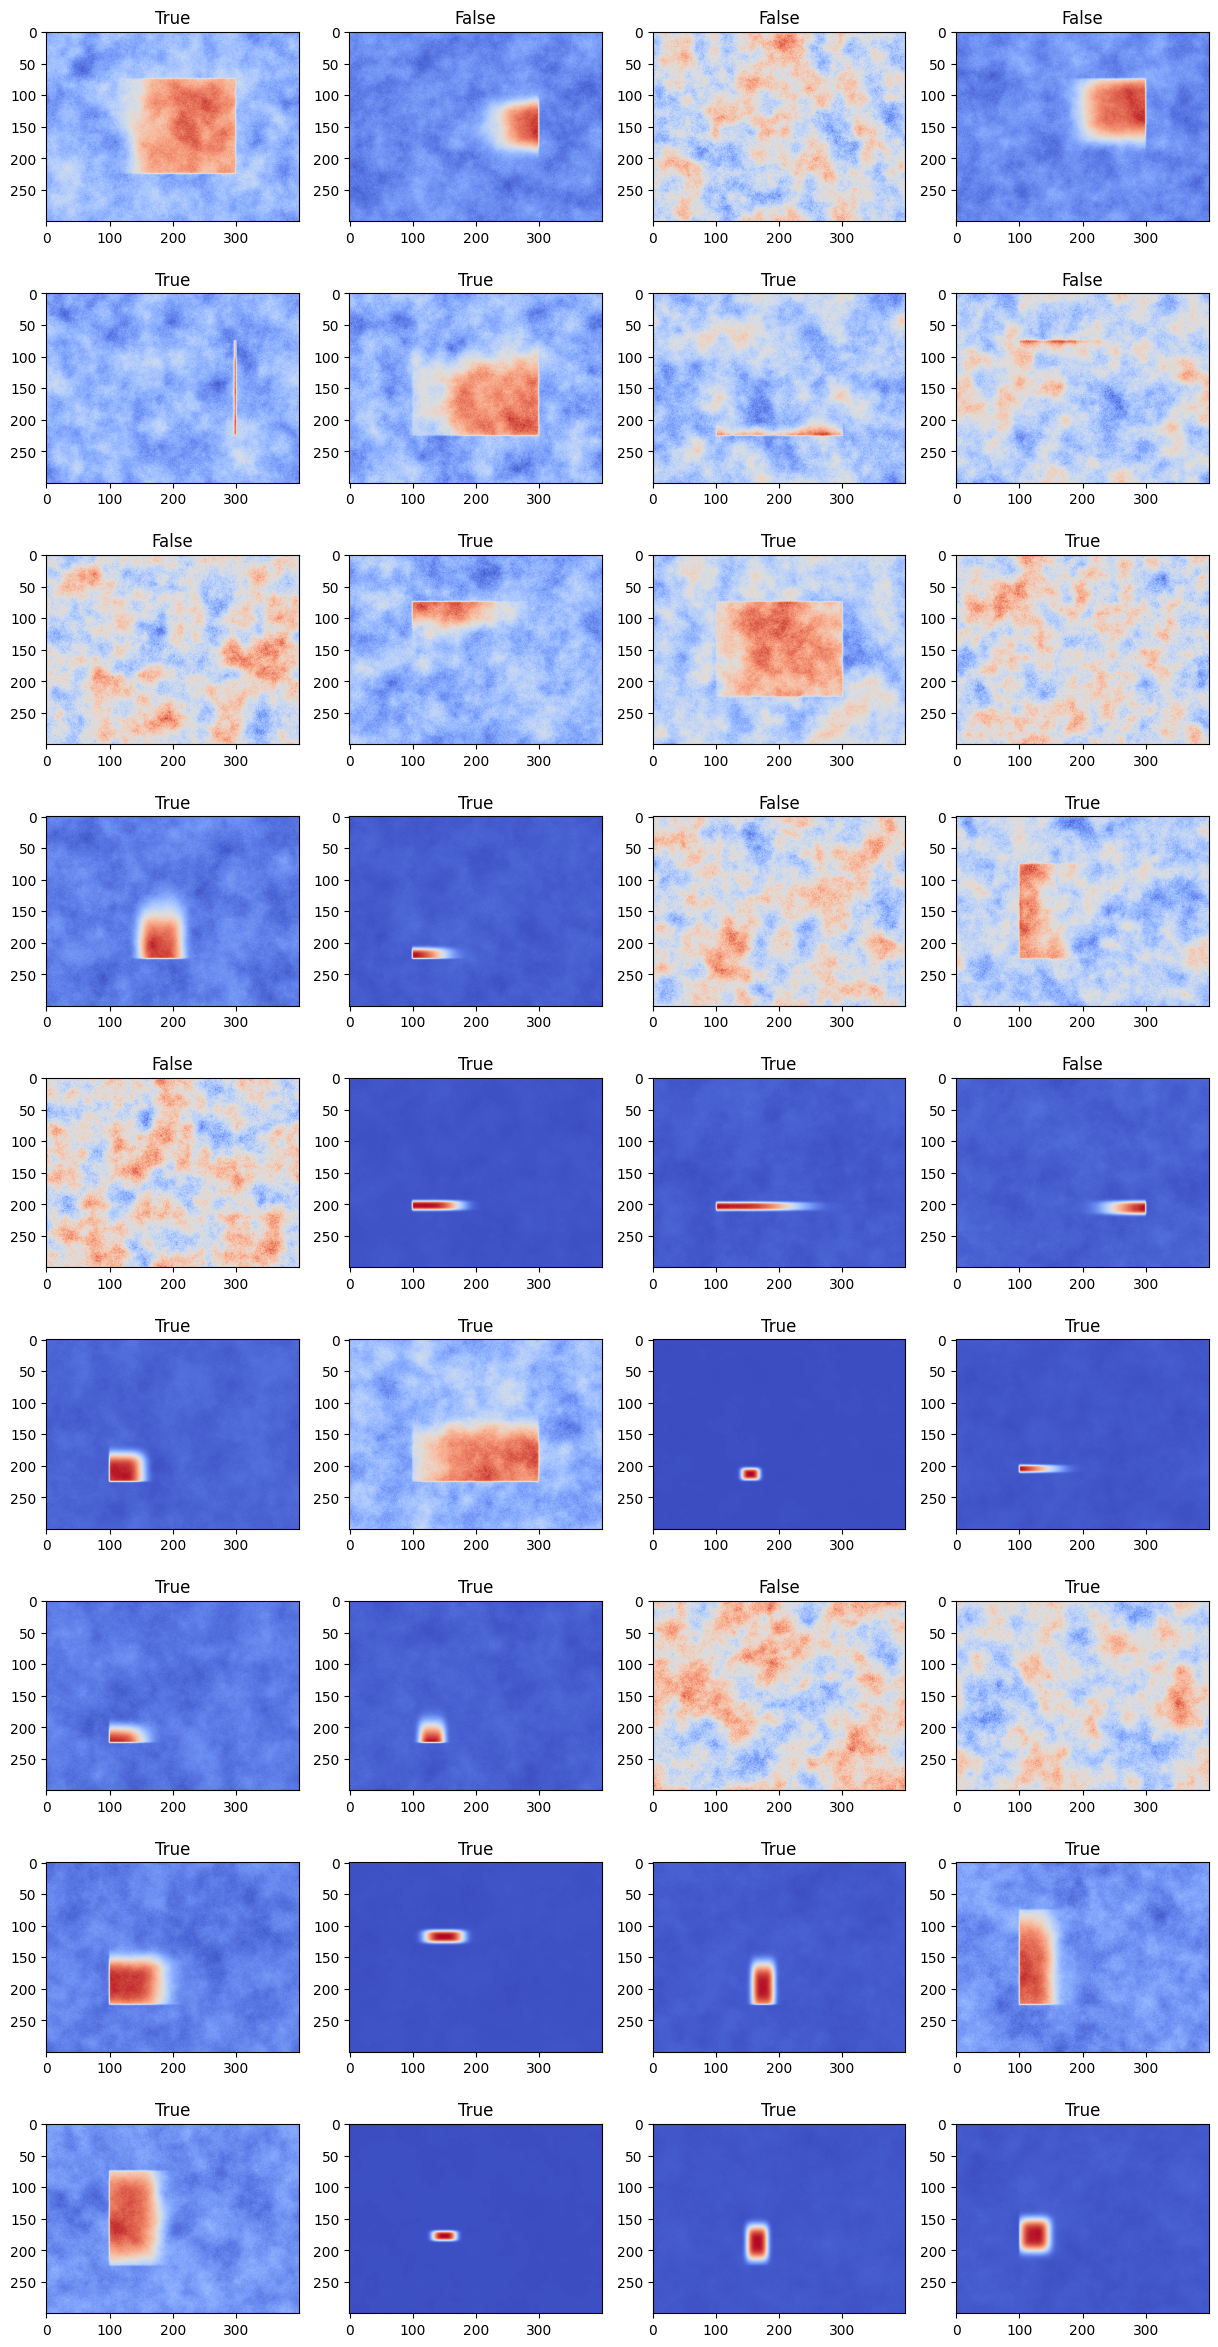

In [203]:
is_good_point = (~torch.isnan(agent.train_targets()["width"]) 
& ~torch.isnan(agent.train_targets()["height"])
& ~torch.isnan(agent.train_targets()["flux"]))

f, axarr = plt.subplots(9,4, figsize=(15, 30))
for i in range(9):
    for j in range(4):
        axarr[i][j].imshow(agent.table.bl_det_image[i*4+j])
        axarr[i][j].set_title(is_good_point[i*4+j].item())

In [132]:
agent.table.loc[0]["bl_det_image"]

array([[ 8.67940802e-04,  2.49404719e-04, -4.96628302e-04, ...,
        -1.72942659e-03,  1.68226602e-03,  1.72496617e-04],
       [ 1.08221235e-04,  1.49041730e-03,  2.34720870e-05, ...,
        -2.67413678e-04,  2.02641208e-04, -7.23394700e-04],
       [ 1.49366913e-04, -1.93925307e-04, -4.20206567e-04, ...,
        -5.72859070e-04, -2.86036359e-03,  5.40471444e-04],
       ...,
       [-1.14573917e-03,  4.04753163e-04,  1.63937606e-03, ...,
        -1.50546233e-03, -1.07967165e-04,  9.67403186e-04],
       [ 7.45126652e-04, -1.29006658e-03, -1.77580167e-03, ...,
        -2.18096623e-03, -1.27647161e-03,  3.34867235e-04],
       [-3.34225377e-04,  8.96408962e-04, -1.42097634e-03, ...,
        -1.15746174e-03,  4.92994023e-04,  5.64957968e-04]])

In [130]:

im = generate_beam(*np.array(torch.rand(4)*12-6))
U, S, Vt = np.linalg.svd(im)

    # Reconstruct the image using the first few singular values
k = 1  # Number of singular values to use
reconstructed = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))


plt.imshow(im)

plt.imshow(reconstructed)

In [1]:
from blop.bayesian.models import construct_single_task_model, train_model

In [172]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.problems.single.knapsack import create_random_knapsack_problem

import numpy as np
from pymoo.core.problem import ElementwiseProblem

class SubsetProblem(ElementwiseProblem):
    def __init__(self,
                 X,
                 y,
                 n_max
                 ):
        super().__init__(n_var=len(X), n_obj=1)
        self.X = X
        self.y = y
        self.n_max = n_max

    def _evaluate(self, x, out, *args, **kwargs):

        _X = self.X[~x]
        _y = self.y[~x]
        # model  = construct_single_task_model(_X, _y, skew_dims=[(0,), (1,), (2,), (3,)])
        # l = model.covar_module.lengthscales.sum().item()
        _y_width = _y[:, 0].unsqueeze(-1)
        _y_height = _y[:, 1].unsqueeze(-1)
        _y_xpos = _y[:, 2].unsqueeze(-1)
        _y_ypos = _y[:, 3].unsqueeze(-1)

        # width_model = construct_single_task_model(_X, _y_width, skew_dims=[(0,), (1,), (2,), (3,)])

        # train_model(width_model)

        # height_model = construct_single_task_model(_X, _y_height, skew_dims=[(0,), (1,), (2,), (3,)])

        # train_model(height_model)
        
        xpos_model = construct_single_task_model(_X, _y_xpos, skew_dims=[(0,), (1,), (2,), (3,)])

        train_model(xpos_model)
        
        ypos_model = construct_single_task_model(_X, _y_ypos, skew_dims=[(0,), (1,), (2,), (3,)])

        train_model(ypos_model)

        #l = width_model.covar_module.lengthscales.sum().item() + height_model.covar_module.lengthscales.sum().item() + 
        l = xpos_model.covar_module.lengthscales.sum().item() + ypos_model.covar_module.lengthscales.sum().item()

        out["F"] = - l #* (_X.max() - _X.min())


X = agent.train_inputs()
y = torch.stack((agent.train_targets()["width"], agent.train_targets()["height"], agent.train_targets()["x_pos"], agent.train_targets()["y_pos"]), 1)
#y = agent.train_targets()["width"].unsqueeze(-1)


mask = ~(X.isnan().any(axis=-1)) & (~torch.isnan(agent.train_targets()["width"]) 
& ~torch.isnan(agent.train_targets()["height"])
& ~torch.isnan(agent.train_targets()["flux"]))

X = X[mask]
y = y[mask]

n_max = 6
problem = SubsetProblem(X, y, n_max)

In [173]:
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.sampling import Sampling


class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_var), False, dtype=bool)

        for k in range(n_samples):
            I = np.random.permutation(problem.n_var)[:problem.n_max]
            X[k, I] = True

        return X


class BinaryCrossover(Crossover):
    def __init__(self):
        super().__init__(2, 1)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape

        _X = np.full((self.n_offsprings, n_matings, problem.n_var), False)

        for k in range(n_matings):
            p1, p2 = X[0, k], X[1, k]

            both_are_true = np.logical_and(p1, p2)
            _X[0, k, both_are_true] = True

            n_remaining = problem.n_max - np.sum(both_are_true)

            I = np.where(np.logical_xor(p1, p2))[0]

            S = I[np.random.permutation(len(I))][:n_remaining]
            _X[0, k, S] = True

        return _X


class MyMutation(Mutation):
    def _do(self, problem, X, **kwargs):
        for i in range(X.shape[0]):
            X[i, :] = X[i, :]
            is_false = np.where(np.logical_not(X[i, :]))[0]
            is_true = np.where(X[i, :])[0]
            X[i, np.random.choice(is_false)] = True
            X[i, np.random.choice(is_true)] = False

        return X

In [174]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

algorithm = GA(
    pop_size=15,
    sampling=MySampling(),
    crossover=BinaryCrossover(),
    mutation=MyMutation(),
    eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 15),
               seed=1,
               verbose=True)

print("Function value: %s" % res.F[0])
print("Subset:", np.where(res.X)[0])

C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       15 | -3.446179E+00 | -4.615277E+00
     2 |       30 | -3.842865E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


     3 |       45 | -3.909467E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message

     4 |       60 | -3.950091E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


     5 |       75 | -3.974969E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


     6 |       90 | -4.003028E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message

     7 |      105 | -4.032862E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message

     8 |      120 | -4.081704E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message

     9 |      135 | -4.095216E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message

    10 |      150 | -4.151015E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


    11 |      165 | -4.196018E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


    12 |      180 | -4.221081E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


    13 |      195 | -4.272415E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


    14 |      210 | -4.277124E+00 | -4.615277E+00


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


    15 |      225 | -4.326619E+00 | -4.615277E+00
Function value: -4.615276708680969
Subset: [ 1  3  5  6  8 16]


IndexError: index 19 is out of bounds for axis 0 with size 19

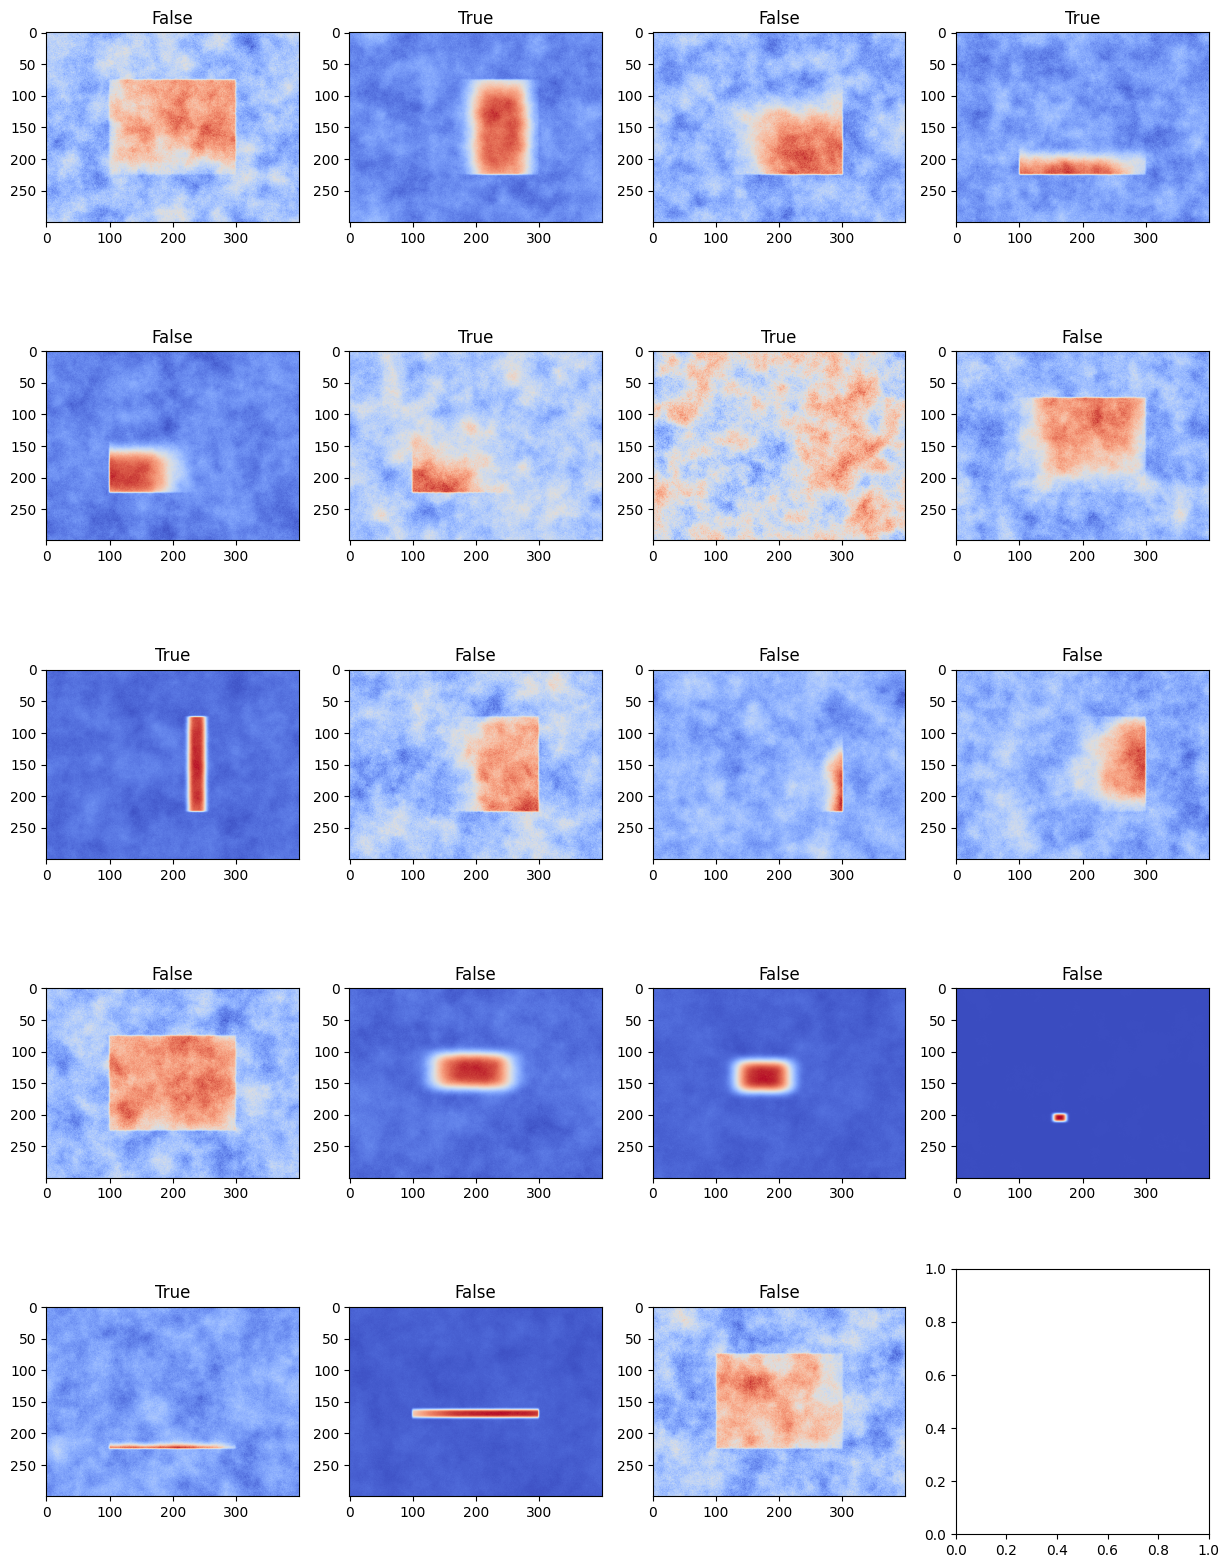

In [175]:
f, axarr = plt.subplots(5,4, figsize=(15, 20))
for i in range(5):
    for j in range(4):
        axarr[i][j].imshow(agent.table["bl_det_image"].values[mask][i*4+j])
        axarr[i][j].set_title(res.X[i*4+j])